Found 3600 images belonging to 5 classes.
Found 76 images belonging to 5 classes.
Found 81 images belonging to 5 classes.
Epoch 1/30
113/113 [==============================] - 32s 240ms/step - loss: 1.7006 - accuracy: 0.4569 - val_loss: 1.6589 - val_accuracy: 0.5526 - lr: 9.0484e-04
Epoch 2/30
113/113 [==============================] - 27s 238ms/step - loss: 1.2607 - accuracy: 0.5997 - val_loss: 1.5373 - val_accuracy: 0.5658 - lr: 8.1873e-04
Epoch 3/30
113/113 [==============================] - 31s 269ms/step - loss: 1.0386 - accuracy: 0.6831 - val_loss: 1.2738 - val_accuracy: 0.6447 - lr: 7.4082e-04
Epoch 4/30
113/113 [==============================] - 29s 251ms/step - loss: 0.9222 - accuracy: 0.7419 - val_loss: 1.3596 - val_accuracy: 0.6316 - lr: 6.7032e-04
Epoch 5/30
113/113 [==============================] - 28s 252ms/step - loss: 0.8507 - accuracy: 0.7764 - val_loss: 1.4113 - val_accuracy: 0.5921 - lr: 6.0653e-04
Epoch 6/30
113/113 [==============================] - 29s 258ms/step

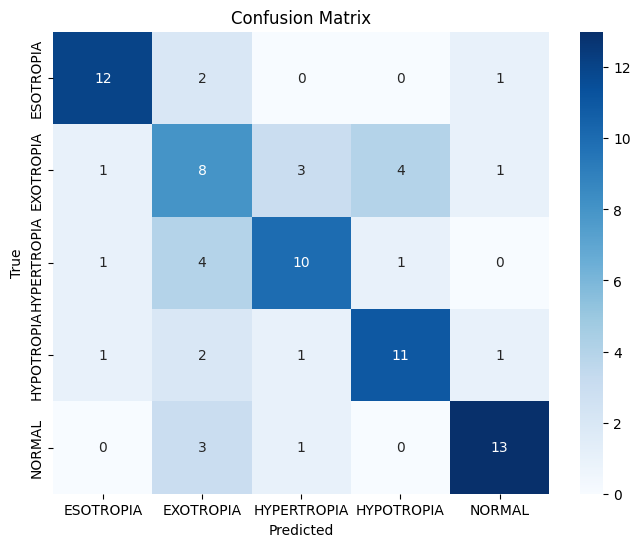

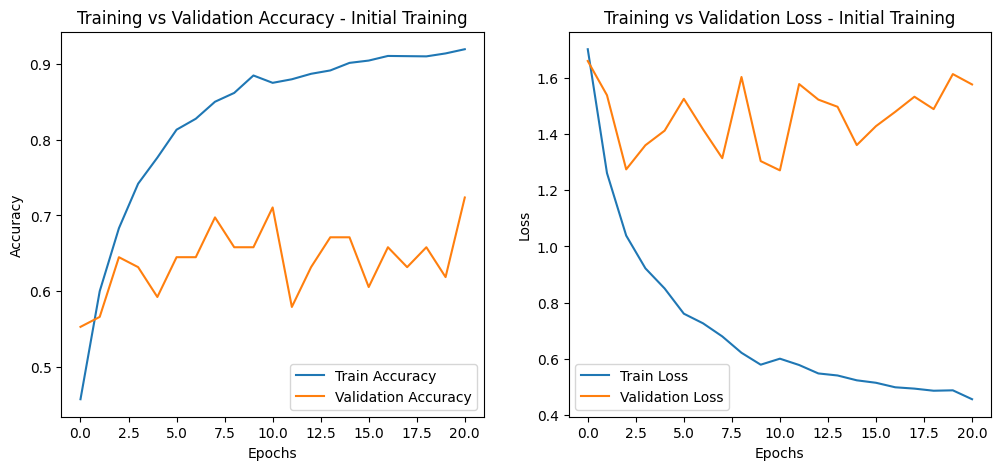

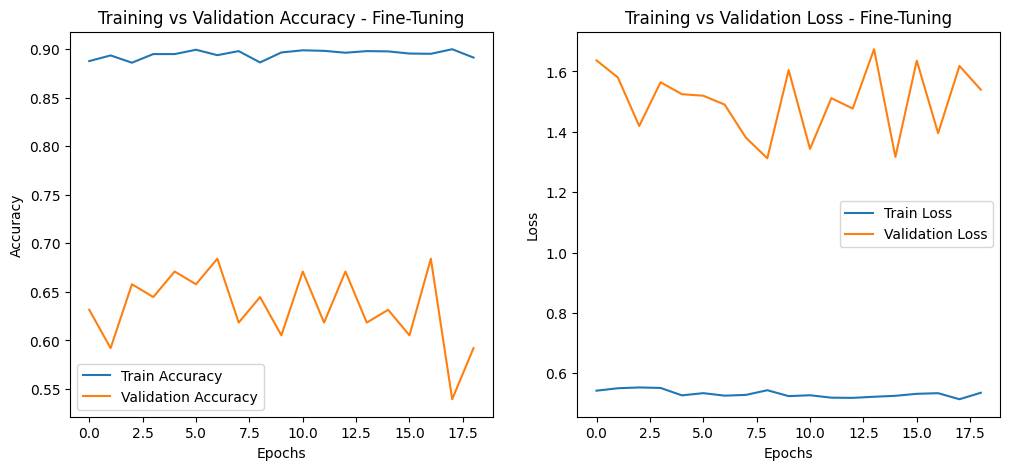

In [4]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Dataset paths
data_train = "E:/Projects/Strabismus/Final_Train_data"
data_val = "E:/Projects/Strabismus/Split_Data/val"
data_test = "E:/Projects/Strabismus/Split_Data/test"

# Image parameters
img_height, img_width = 224, 224
batch_size = 32
num_classes = 5

# Data Augmentation
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(data_train, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
val_generator = datagen.flow_from_directory(data_val, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_generator = datagen.flow_from_directory(data_test, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', shuffle=False)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))

# Load VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  

# Custom model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Learning rate scheduler (Exponential Decay)
def lr_scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1)

callback_lr = LearningRateScheduler(lr_scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(train_generator, epochs=30, validation_data=val_generator, class_weight=class_weight_dict, callbacks=[callback_lr, reduce_lr, early_stopping])

# Gradual fine-tuning
for layer in base_model.layers[15:]:  
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history_finetune = model.fit(train_generator, epochs=30, validation_data=val_generator, class_weight=class_weight_dict, callbacks=[callback_lr, reduce_lr, early_stopping])

# Evaluate on test set
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Function to plot learning curve
def plot_learning_curve(history, title):
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Training vs Validation Accuracy - {title}')
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training vs Validation Loss - {title}')
    
    plt.show()

# Call the function for both training phases
plot_learning_curve(history, "Initial Training")
plot_learning_curve(history_finetune, "Fine-Tuning")